In [16]:
import numpy as np
from statsmodels.stats.weightstats import ztest, ttest_ind
from scipy.stats import chi2_contingency, fisher_exact
from scipy.stats import norm, expon, t, hypergeom, chi2
from scipy import mean, std
import matplotlib.pyplot as plt

In [17]:
def choice(ps):
    return np.random.choice(len(ps), p=ps)

def simulate_abtest(funnels, N):
    traffic_split = [x[1] for x in funnels]
    observations = np.zeros([len(funnels), len(funnels[0][0])])
    for _ in range(N):
        which_funnel = choice(traffic_split)
        funnel_outcome = choice(funnels[which_funnel][0])
        observations[which_funnel][funnel_outcome] += 1
    return observations

In [18]:
def abtest_episode(funnels, N, prior_observations=None):
    observations = simulate_abtest(funnels, N)
    if prior_observations is not None:
        observations += prior_observations
    p = chi2_contingency(observations, correction=False)[1]
    return observations, p

def early_stopping_simulation(funnels, num_simulations, episodes, alphas):
    hits = 0
    for _ in range(num_simulations):
        observations = None
        for i in range(len(episodes)):
            observations, p = abtest_episode(funnels, episodes[i], observations)
            if p <= alphas[i]:
                hits += 1
                break
    p = hits / num_simulations
    return p

In [43]:
T = 2000

funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]

In [44]:
Ns = [3000]
alphas = [0.05]

p = early_stopping_simulation(funnels, T, Ns, alphas)
print('False positive ratio: %.3f' % p)

False positive ratio: 0.057


In [22]:
Ns = [1000] * 3
alphas = [0.05] * 3

p = early_stopping_simulation(funnels, T, Ns, alphas)
print('False positive ratio: %.3f' % p)

False positive ratio: 0.105


In [23]:
Ns = [1000] * 3
alphas = [0.0221] * 3
# Pocock boundary from https://en.wikipedia.org/wiki/Pocock_boundary

p = early_stopping_simulation(funnels, T, Ns, alphas)
print('False positive ratio: %.3f' % p)

False positive ratio: 0.052


In [25]:
Ns = [1000] * 3
alphas = [0.001, 0.001, 0.05]
# Haybittle-Peto boundary from https://en.wikipedia.org/wiki/Haybittle%E2%80%93Peto_boundary

p = early_stopping_simulation(funnels, T, Ns, alphas)
print('False positive ratio: %.3f' % p)

False positive ratio: 0.049


In [32]:
def repeated_significances(funnels, episodes):
    results = []
    observations = None
    for i in range(len(episodes)):
        observations, p = abtest_episode(funnels, episodes[i], observations)
        N = np.sum(observations)
        results.append((N, p))
    return results

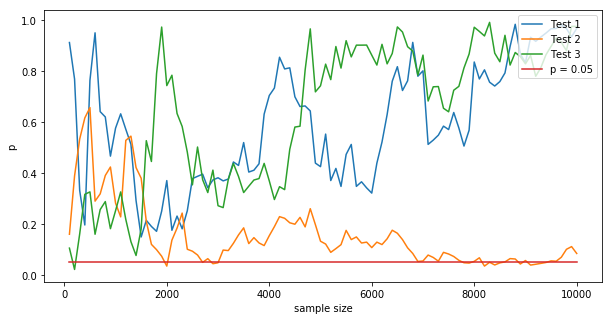

In [40]:
Ns = [100] * 100

results1 = repeated_significances(funnels, Ns)
results2 = repeated_significances(funnels, Ns)
results3 = repeated_significances(funnels, Ns)

plt.figure(figsize=(10,5))
plt.xlabel('sample size')
plt.ylabel('p')
plt.plot([x[0] for x in results1], [x[1] for x in results1])
plt.plot([x[0] for x in results2], [x[1] for x in results2])
plt.plot([x[0] for x in results3], [x[1] for x in results3])
plt.plot([x[0] for x in results3], [0.05 for _ in results3])
plt.legend(['Test 1', 'Test 2', 'Test 3', 'p = 0.05'], loc='upper right')
plt.show()